At a certain lab where I was an intern, other inhabitants shared a similar fate.

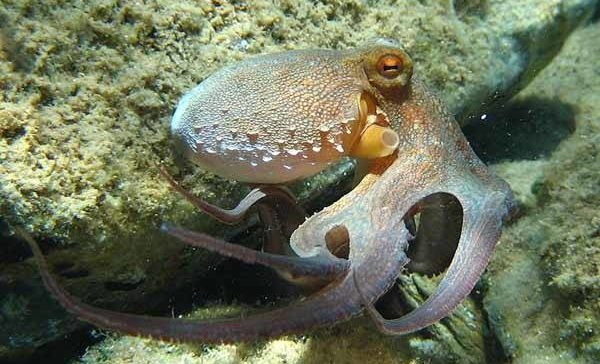

Thus they (were) studied in captivity. One such study was about their reproduction, which is influenced by 
several factors, such as light, water temperature, and possibly moon phases.

For this study, we considered only water temperature (understood to be the most important), and we want to predict when they lay their eggs.

As complex as their reproduction process might be, as machine learning users we need not
concern ourselves much with the biology (we should of course, consult with the experts).
Important to us is that we have a predictor variable $X$, which is a time series of temperature data, and a binary target variable $y$ which has a $1$ each day that an octopi has laid their eggs.

Of course, they all share the same water, if in different tanks.


First we must do a bit of data formatting. The raw temperature data in csv looks like this:

``` 
Ano;Mes;Dia;Fecha;Hora;Temp
2009;5;22;2009522;9;20,3
2009;5;22;2009522;10;20,3
2009;5;22;2009522;15;20,5
```

We want to get it in a nice pandas dataframe:

In [662]:



# Read and format temperature data
df = pd.read_csv('temperaturapulpos.csv', index_col=None, sep=';', decimal=",")
df['Fecha'] = pd.to_datetime(df['Ano'].astype(str) + df['Mes'].astype(str).str.zfill(2) + df['Dia'].astype(str).str.zfill(2))
df.drop(['Ano', 'Mes', 'Dia', 'Hora'], axis=1, inplace=True)

# Daily means
df = df.groupby('Fecha', as_index=False).mean()
df.set_index('Fecha', inplace=True)

# Data from 2012 onward
df = df[df.index >= '2012']

# Laying data
file_path = 'puestaspulpos.xlsx'
df2 = pd.read_excel(file_path)
df2 = df2.iloc[:366]
df2 = df2.drop(['Unnamed: 14'], axis=1)
df2.fillna(0, inplace=True)

# Melt df
df3 = df2.melt(id_vars='Fecha', value_vars=list(range(2012,2024+1)  )  )

# Convert 'Fecha' column to datetime format
df3['Fecha'] = pd.to_datetime(df3['Fecha'])

# Replace the year in 'Fecha' with the year from 'variable'
df3['Fecha'] = df3.apply(lambda row: row['Fecha'].replace(year=row['variable']), axis=1)

# Make 'Fecha' the index
df3.set_index('Fecha', inplace=True)

df3.drop('variable', axis=1, inplace=True)
df3.rename(columns={'value': 'Puestas'}, inplace=True)

# Replace 2 and 3 with 1
df3[df3 != 0] = 1

# Merge
df = pd.merge(df, df3, on='Fecha', how='inner')
display(df)
df.describe()

,Temp,Puestas
Fecha,,
2012-01-01,19.608333,0.0
2012-01-02,19.600000,0.0
2012-01-03,19.537500,0.0
2012-01-04,19.545833,0.0
2012-01-05,19.595833,0.0
...,...,...
2024-03-11,20.500000,0.0
2024-03-12,20.625000,0.0
2024-03-13,20.665217,0.0


,Temp,Puestas
count,3980.000000,3980.000000
mean,21.691412,0.031407
std,1.941653,0.174437
min,17.620833,0.000000
25%,20.003125,0.000000
50%,21.706250,0.000000
75%,23.437500,0.000000
max,26.187500,1.000000


Importantly, we made a TimeSeries object by setting the index of the dataframe to datetime type. 

We also took daily means and replaced some days that had 2 or 3 layings with just 1
(this makes it easier for binary classification)

Observe that most days, of course, there are no layings (puestas = 0)

Let us make a rough plot of the data to get an idea:

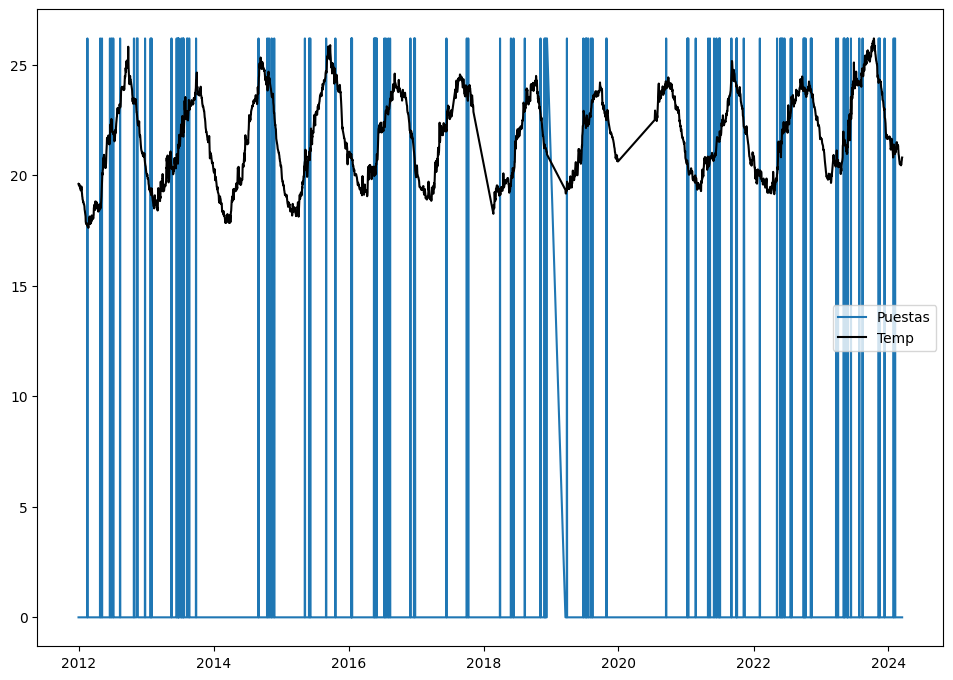

In [663]:
plt.figure(figsize=(11.69,8.27))
plt.plot(df.index, df['Puestas']*np.max(df['Temp']), label='Puestas')
plt.plot(df.index, df['Temp'], label='Temp', color='black')
plt.legend()
plt.show()

It becomes clear that Temperature is a stationary time series. It becomes less clear how we will predict a binary outcome from this.

Following traditional wisdom, here is another plot.

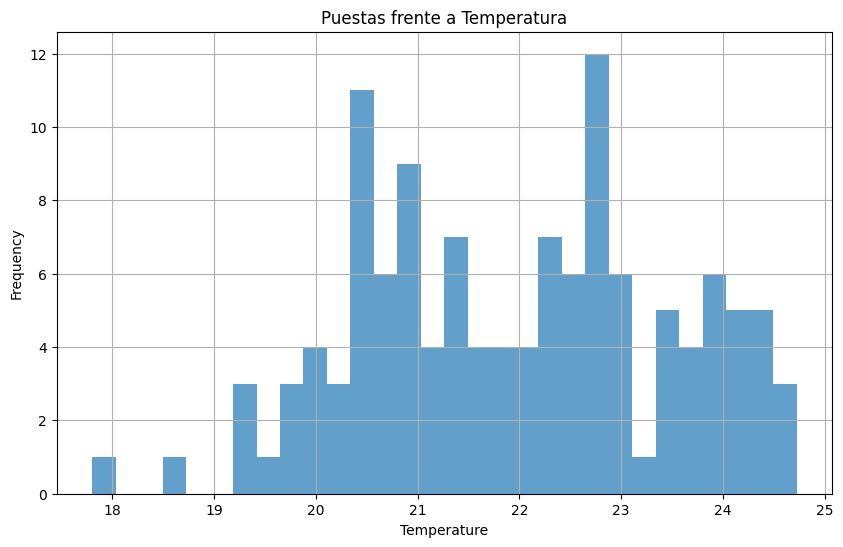

125.0

In [664]:
temperature_with_event = df['Temp'][df['Puestas'] == 1]

# Create histogram
plt.figure(figsize=(10, 6))
#plt.hist(df['Temp'], bins=30, alpha=0.7, label='All Temperatures')
plt.hist(temperature_with_event, bins=30, alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Puestas frente a Temperatura')
plt.grid(True)
plt.show()
np.sum(df['Puestas'])

While we cant tell much, they certainly dont like to have a cold temperature on their laying day. And they seem to like 20.5 and 22.5

Note also that while there are 4000 data entries, there are only 125 nonzero entries.

It is wise then to take weekly means to reduce this class imbalance. We also can't expect to predict such a complex event with 1-day precision. We will simply put a 1 when there was a laying that week.


In [665]:
df = pd.read_csv('out.csv', index_col=0)
df.index = pd.to_datetime(df.index)


weekly_means = df.resample('W').mean()
df = weekly_means
df.dropna(inplace=True)
df['Puestas'][df['Puestas'] != 0] = 1
df.describe()
df

,Temp,Puestas
Fecha,,
2012-01-01,19.608333,0.0
2012-01-08,19.544695,0.0
2012-01-15,19.404891,0.0
2012-01-22,19.242262,0.0
2012-01-29,18.814105,0.0
...,...,...
2024-02-18,21.414286,0.0
2024-02-25,21.207143,0.0
2024-03-03,20.662926,0.0


Now, what model should we use? To keep it explainable, we decided on a simple model: Decision Trees. 
(the truth is, many other models were tried, and this worked the best)

Obviously, we cant predict the layings of a day with the temperature of that day. So we need to create something called Lag Features.

We will create copies of our Temperature variable that are 'shifted', ie. Lag_4 will be the temperature 4 weeks ago. 

Lets also do a first decision tree on the whole data. We need to give it `class_weight='balanced'` to account for the class imbalance.

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84       474
         1.0       0.36      0.55      0.44       100

    accuracy                           0.75       574
   macro avg       0.63      0.67      0.64       574
weighted avg       0.80      0.75      0.77       574


 Accuracy score: 75.26%


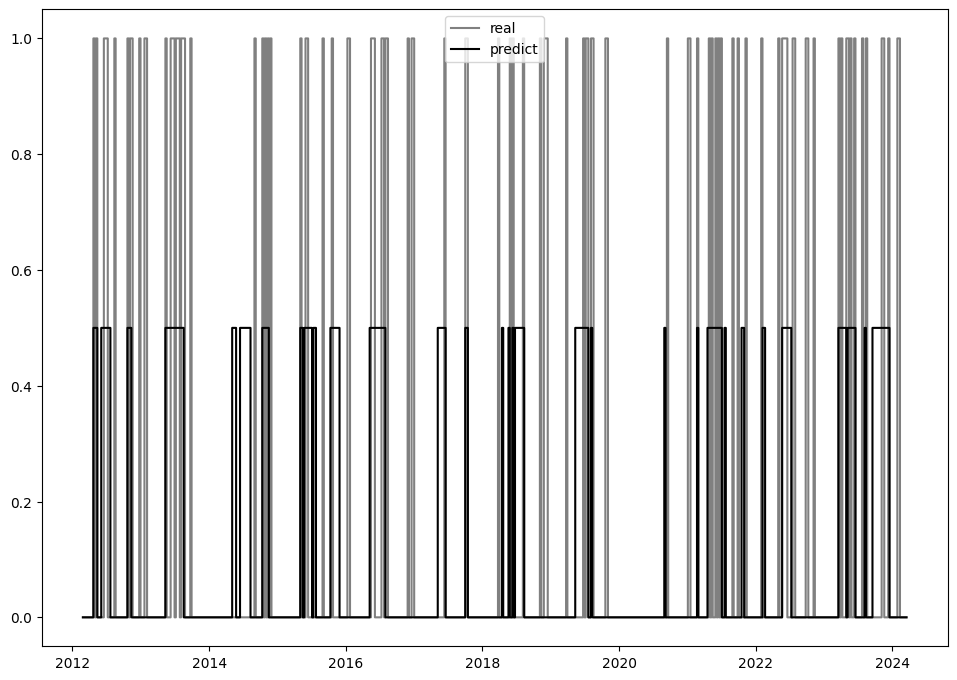

In [666]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Create lag features for Temp
for i in [2,4,6,8]:
    df[f'Lag_{i}'] = df['Temp'].shift(i)

# Drop NaN values
df.dropna(inplace=True)
df.drop(['Temp'], axis=1, inplace=True)

# Define target variable y (Puestas) and input features X (lagged temperature data)
y = df['Puestas']
X = df.drop('Puestas', axis=1)

# Initialize model
model = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
#model = KNeighborsClassifier(n_neighbors=5)

# Fit the model to entire dataset
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
print(classification_report(y, y_pred))
accuracy = accuracy_score(y, y_pred)
print(f'\n Accuracy score: {accuracy * 100:.2f}%')

plt.figure(figsize=(11.69,8.27))
plt.step(X.index, y, label='real', color='gray')
plt.step(X.index, y_pred*0.5, label='predict', color='black')
plt.legend()
plt.show()

75% accuracy seems OK, right? No, when most of your data is 0. Then your model could just predict 0.
This is why sci-kit has `balanced_accuracy_score`

In [667]:
from sklearn.metrics import balanced_accuracy_score
accuracy = balanced_accuracy_score(y, y_pred)
print(f'\n Balanced Accuracy score: {accuracy * 100:.2f}%')


 Balanced Accuracy score: 67.27%


Okay, it dropped a bit, but still acceptable. Visually we can see it doing something, too.

Where did the `max_depth=3` parameter come from? Repeated testing, on a holdout validation set. It was found to be the best value, to prevent overfitting. In fact, with the default settings, you would get 100% training accuracy.

Speaking of holdout validation, we can't do the usual one. Our data needs to stay ordered across time. We also don't have alot of it (of nonzero data, that is), so I decided on a single split.

`size` is the training set size


 Balanced Accuracy score: 56.28%


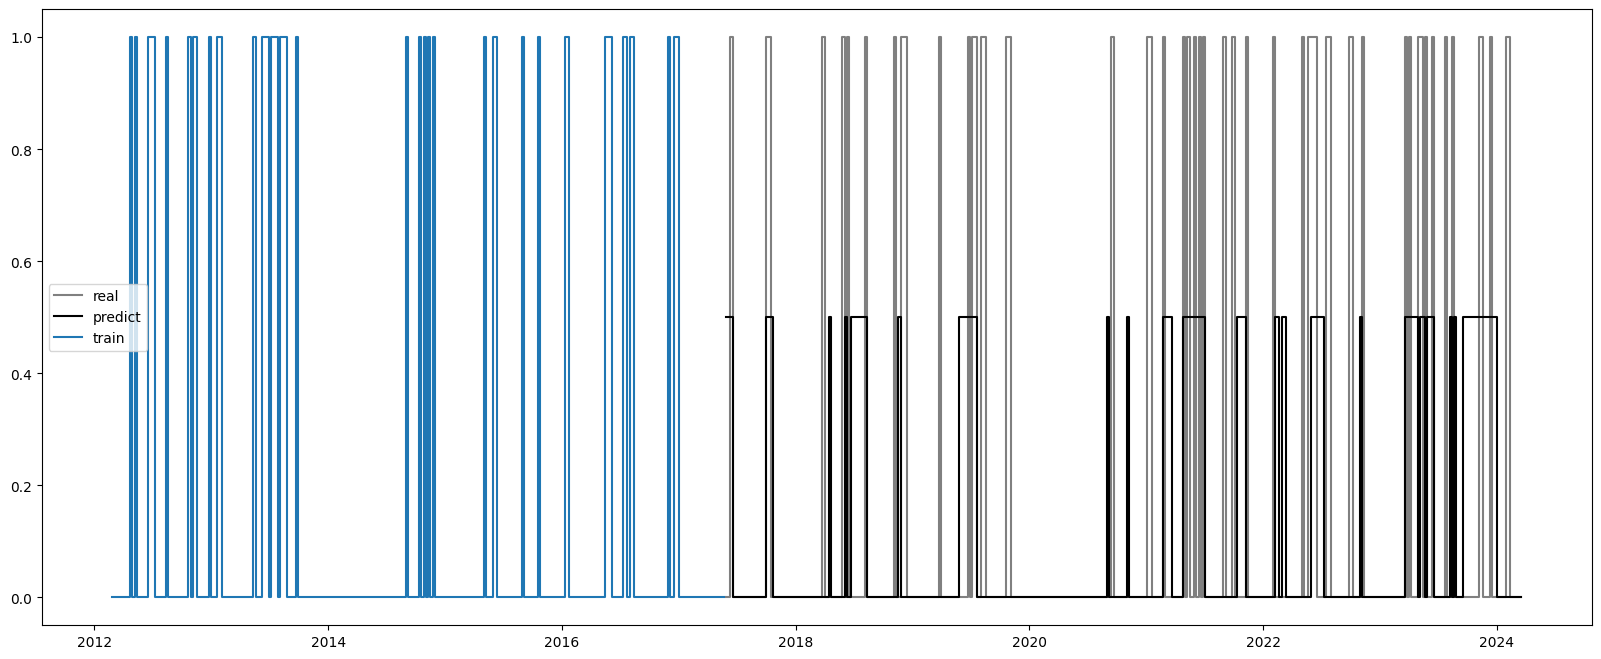

0.5628306878306879

In [668]:
def split_cv(df, plot, size):
    split_index = len(df) - size
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    
    y_train = train_data['Puestas']
    X_train = train_data.drop(['Puestas'], axis=1)

    y_test = test_data['Puestas']
    X_test = test_data.drop(['Puestas'], axis=1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    #accuracy2 = accuracy_score(y_pred, y_test)
    accuracy2 = balanced_accuracy_score(y_pred, y_test)
    #accuracy2 = recall_score(y_pred, y_test)
    
    if plot:
        #print(f'\n Accuracy score: {accuracy1 * 100:.2f}%')
        print(f'\n Balanced Accuracy score: {accuracy2 * 100:.2f}%')
        #print(f'\n Recall score: {accuracy3 * 100:.2f}%')
        plt.figure(figsize=(20,8))
        plt.step(X_test.index, y_test, label='real', color='gray')

        plt.step(X_test.index, y_pred*0.5, label='predict', color='black')

        plt.step(X_train.index, y_train, label='train', color='tab:blue')
        plt.legend()
        plt.show()

    return accuracy2, X_test

split_cv(df, True, 300)[0]

Now, this is just a single split. So maybe we got lucky on our cutoff point? This is why we wrote a function.
Lets take the mean balanced accuracy score varying the test size.

In [669]:
np.mean([split_cv(df, False, x)[0] for x in range(100,300+1, 50)])

0.551940687292534

It's about the same. Now, 55% is not a good score. However, there are near misses, and we are more interested in predicting the phases that egg laying occurs in,
rather than exactly each individual one. This is why the metrics are less useful, while the plot is more informative.

Let us now try to interpret the model. Luckily since its a decision tree with depth 3, that should be doable. Lets keep the best of the previous models.

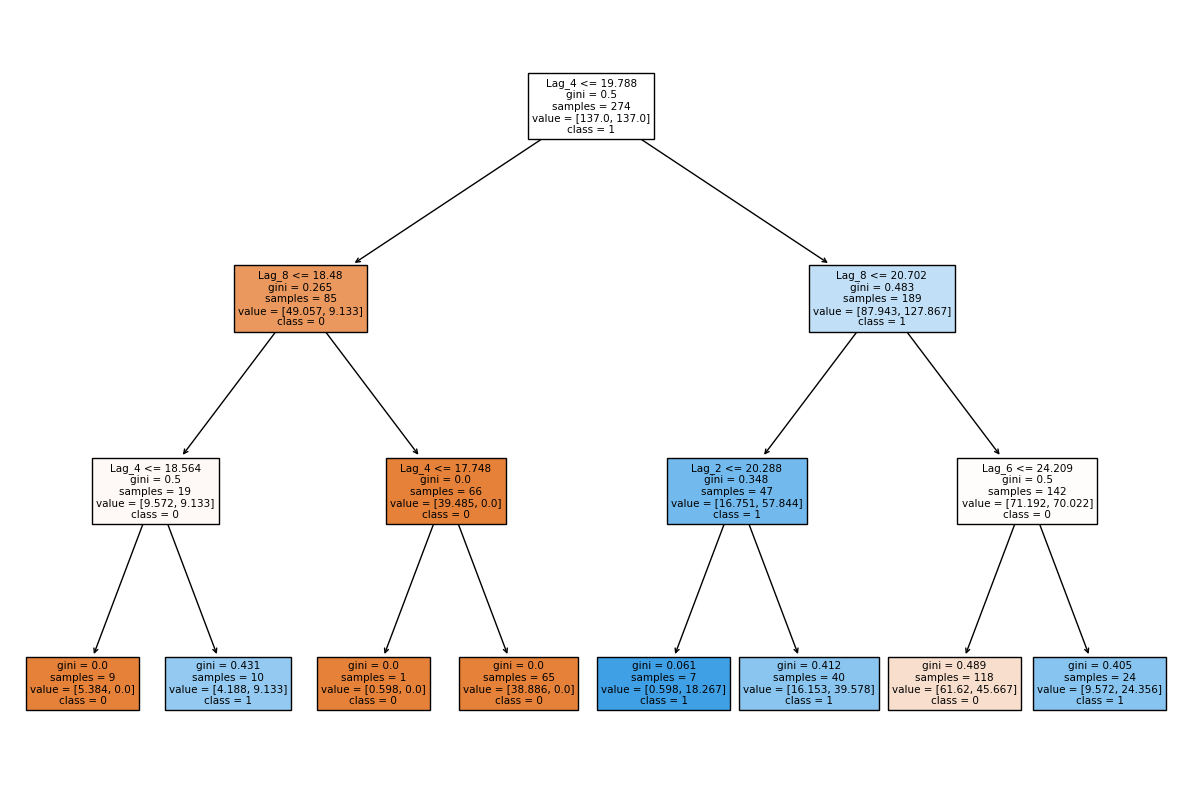

In [670]:
X_test = split_cv(df, False, 300)[1]

from sklearn.tree import plot_tree
plt.figure(figsize=(15,10))
plot_tree(model, filled=True, feature_names=X_test.columns, class_names=['0', '1'])
plt.show()

We see there are 4 paths to classify a 1. Biologists suspect the temperature signal should happen around 1.5 months before laying. So we are most interested in the rightmost path.
It says the temperature should rise, 8 weeks prior, from 20.7 to 24.2 at 6 weeks prior, and be larger than 19.8 4 weeks prior. Theres our signal.

Observe also the leftmost path. It says if the temperature is cold all the way, we will get a 0.

Now, while these are not hard results, they serve as a first suggestion for controlled experimentation.

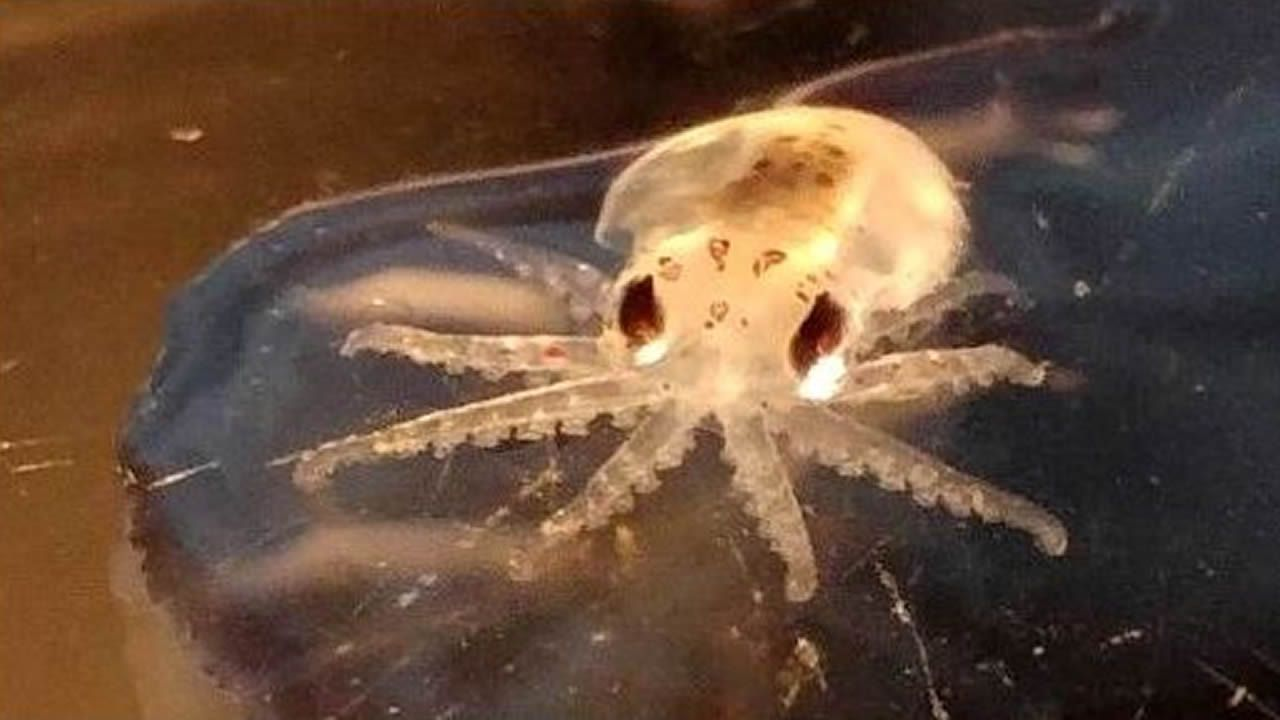